In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import scipy

In [2]:
experiment = "CA1_clust4-60_AP"
setting = "comb_pred"

prob_all = np.load("/media/hdd01/sklee/"+experiment+"/"+setting+"/gru_l20_h40_0.2ms_test.npy").flatten()
spk = np.load("/media/hdd01/sklee/"+experiment+"/data/spike_train_0.2ms.npy")[980*50000:].flatten()
prec_all, rec_all, thresh_list = precision_recall_curve(spk, prob_all)
#thresh_list = thresh_list[:-2]
prob_all_next = np.zeros_like(prob_all)
prob_all_next[:-1] = prob_all[1:]

In [3]:
ms_list = [1,2,5,10]
thresh_list_choose = np.arange(0,thresh_list.shape[0], 10)

#pr_array = np.empty((4,thresh_list.shape[0],2))
#tp_array = np.empty((4,thresh_list.shape[0]))
#fp_array = np.empty((4,thresh_list.shape[0]))
#tn_array = np.empty((4,thresh_list.shape[0]))
#fn_array = np.empty((4,thresh_list.shape[0]))

pr_array = np.empty((4,thresh_list_choose.shape[0],2))
tp_array = np.empty((4,thresh_list_choose.shape[0]))
fp_array = np.empty((4,thresh_list_choose.shape[0]))
tn_array = np.empty((4,thresh_list_choose.shape[0]))
fn_array = np.empty((4,thresh_list_choose.shape[0]))

spk_count = np.empty((4,thresh_list_choose.shape[0]))

for n in tnrange(4):
    bin_size = ms_list[n] * 5
    
    #for i in tnrange(thresh_list.shape[0]):
    for i in tnrange(thresh_list_choose.shape[0]):
        #thresh = thresh_list[i]
        thresh = thresh_list[thresh_list_choose[i]]
        #prob_new = np.copy(prob_all)
        spk_pred = np.zeros((20*50000))
        
        spk_idx = np.where((prob_all < thresh) & (prob_all_next >= thresh))[0]
        spk_pred[spk_idx] = 1
        spk_count[n,i] = np.sum(spk_pred)
        
        #prob_new[prob_all<thresh] = 0
        #prob_new[prob_all>=thresh] = 1
        
        prob_bin = scipy.ndimage.convolve1d(spk_pred.reshape(20,50000), np.ones((bin_size)), 1)
        prob_bin = prob_bin[:,bin_size-1:-bin_size+1]
        #prob_bin /= bin_size
        prob_bin[prob_bin>0] = 1
        spk_bin = scipy.ndimage.convolve1d(spk.reshape(20,50000), np.ones((bin_size)), 1)
        spk_bin = spk_bin[:,bin_size-1:-bin_size+1]
        #spk_bin /= bin_size
        spk_bin[spk_bin>0] = 1
        
        tp = np.where((prob_bin == 1) & (spk_bin == 1))[0].size
        fp = np.where((prob_bin == 1) & (spk_bin == 0))[0].size
        tn = np.where((prob_bin == 0) & (spk_bin == 0))[0].size
        fn = np.where((prob_bin == 0) & (spk_bin == 1))[0].size
        
        tp_array[n,i] = tp
        fp_array[n,i] = fp
        tn_array[n,i] = tn
        fn_array[n,i] = fn
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        pr_array[n,i,0] = prec
        pr_array[n,i,1] = rec

<ipython-input-3-a3ebb918fdf1>:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for n in tnrange(4):


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-3-a3ebb918fdf1>:22: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(thresh_list_choose.shape[0]):


  0%|          | 0/6768 [00:00<?, ?it/s]

  0%|          | 0/6768 [00:00<?, ?it/s]

  0%|          | 0/6768 [00:00<?, ?it/s]

  0%|          | 0/6768 [00:00<?, ?it/s]

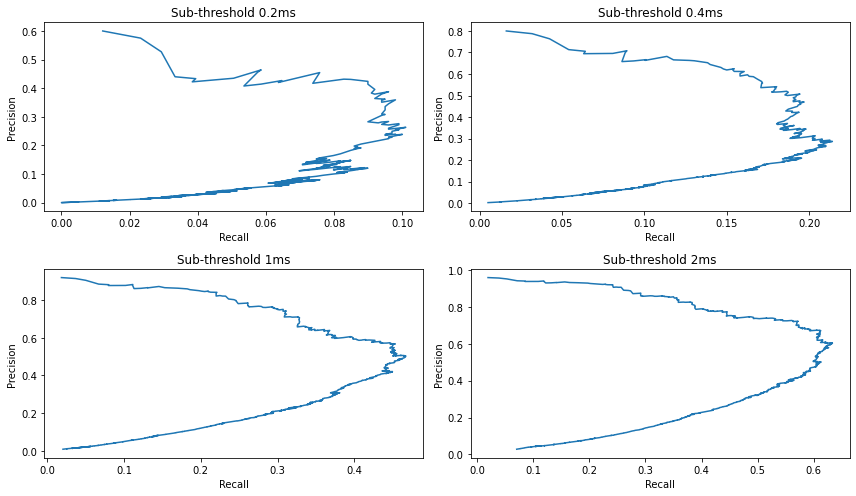

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

for row in range(2):
    for col in range(2):
        idx = row*2+col
        axs[row,col].plot(pr_array[idx,:,1],
                          pr_array[idx,:,0])
        #axs[row,col].set_title(str(metrics.auc(pr_array[idx,:,1],
            #pr_array[idx,:,0])))
        #print(metrics.auc(pr_array[:,:thresh_list_choose.shape[0]][idx,:,1],
            #pr_array[:,:thresh_list_choose.shape[0]][idx,:,0]))
        axs[row,col].set_xlabel("Recall")
        axs[row,col].set_ylabel("Precision")
        
axs[0,0].set_title("Sub-threshold 0.2ms")
axs[0,1].set_title("Sub-threshold 0.4ms")
axs[1,0].set_title("Sub-threshold 1ms")
axs[1,1].set_title("Sub-threshold 2ms")

fig.tight_layout()

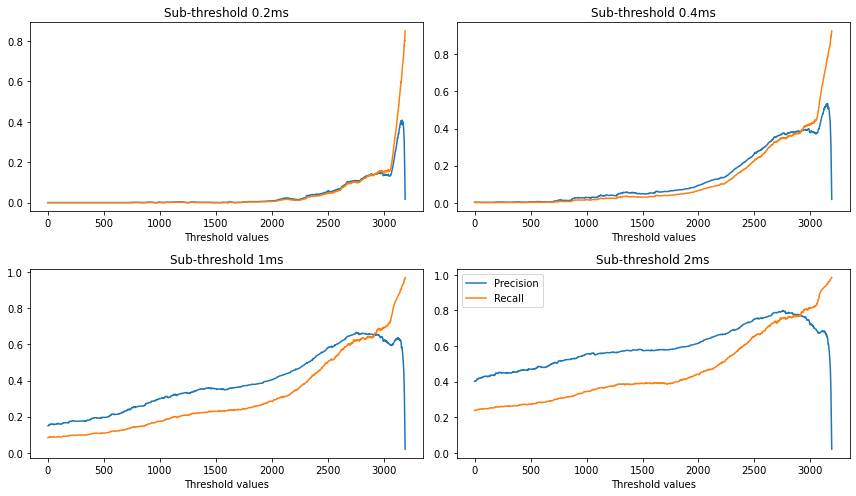

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))
for row in range(2):
    for col in range(2):
        idx = row*2+col
        axs[row,col].plot(pr_array[idx,:,1], label="Precision")
        axs[row,col].plot(pr_array[idx,:,0], label="Recall")
        axs[row,col].set_xlabel("Threshold values")

axs[0,0].set_title("Sub-threshold 0.2ms")
axs[0,1].set_title("Sub-threshold 0.4ms")
axs[1,0].set_title("Sub-threshold 1ms")
axs[1,1].set_title("Sub-threshold 2ms")

plt.legend()

fig.tight_layout()

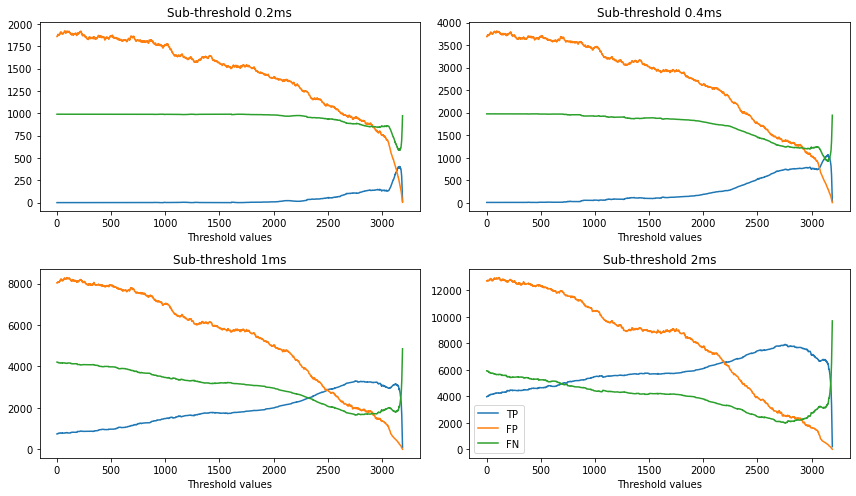

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))
for row in range(2):
    for col in range(2):
        idx = row*2+col
        axs[row,col].plot(tp_array[idx,:], label="TP")
        axs[row,col].plot(fp_array[idx,:], label="FP")
        #axs[row,col].plot(tn_array[idx,:], label="TN")
        axs[row,col].plot(fn_array[idx,:], label="FN")
        axs[row,col].set_xlabel("Threshold values")

axs[0,0].set_title("Sub-threshold 0.2ms")
axs[0,1].set_title("Sub-threshold 0.4ms")
axs[1,0].set_title("Sub-threshold 1ms")
axs[1,1].set_title("Sub-threshold 2ms")

plt.legend()

fig.tight_layout()

In [ ]:
na_true = [0.6172273108361946, 0.7165850106931515, 0.8211546270828541, 0.8808807762581149]
comb_pred = [0.23654430989973957, 0.3743840811548183, 0.5673273200188514, 0.6982096198114366]
nona_true = [0.17978516574933012, 0.30608746043204177, 0.5102260353139435, 0.6661733598641558]


In [4]:
#np.save("/media/hdd01/sklee/"+experiment+"/"+setting+"/prec_rec_"+setting+".npy", pr_array)

In [3]:
ms_list = [1,2,5,10]
auc_array = np.zeros((4,13,20))

for i in tnrange(4):
    length = int(50000/ms_list[i]/5)
    ap_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    nona_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/nona_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    comb_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    whole_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    diff_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/diff_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    diff_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/diff_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    nona_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/nona_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_late_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_late/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    comb_pred_late_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred_late/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_nona_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_nona_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_pred_nona_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_pred_nona_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_noise_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_noise/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    
    spk_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_"+str(ms_list[i])+"ms.npy")[980*length:].flatten()
    
    for j in range(20):
        ap_true = ap_true_all[j*length:(j+1)*length]
        na_true = na_true_all[j*length:(j+1)*length]
        nona_true = nona_true_all[j*length:(j+1)*length]
        comb_pred = comb_pred_all[j*length:(j+1)*length]
        whole_pred = whole_pred_all[j*length:(j+1)*length]
        diff_true = diff_true_all[j*length:(j+1)*length]
        diff_pred = diff_pred_all[j*length:(j+1)*length]
        nona_pred = nona_pred_all[j*length:(j+1)*length]
        na_true_late = na_true_late_all[j*length:(j+1)*length]
        comb_pred_late = comb_pred_late_all[j*length:(j+1)*length]
        na_true_nona_pred = na_true_nona_pred_all[j*length:(j+1)*length]
        na_pred_nona_true = na_pred_nona_true_all[j*length:(j+1)*length]
        na_true_noise = na_true_noise_all[j*length:(j+1)*length]
        spk = spk_all[j*length:(j+1)*length]
        
        prec_comb_pred, rec_comb_pred, _ = precision_recall_curve(spk, comb_pred)
        prec_whole_pred, rec_whole_pred, _ = precision_recall_curve(spk, whole_pred)
        prec_ap_true, rec_ap_true, _ = precision_recall_curve(spk, ap_true)
        prec_na_true, rec_na_true, _ = precision_recall_curve(spk, na_true)
        prec_nona_true, rec_nona_true, _ = precision_recall_curve(spk, nona_true)
        prec_diff_true, rec_diff_true, _ = precision_recall_curve(spk, diff_true)
        prec_diff_pred, rec_diff_pred, _ = precision_recall_curve(spk, diff_pred)
        prec_nona_pred, rec_nona_pred, _ = precision_recall_curve(spk, nona_pred)
        prec_na_true_late, rec_na_true_late, _ = precision_recall_curve(spk, na_true_late)
        prec_comb_pred_late, rec_comb_pred_late, _ = precision_recall_curve(spk, comb_pred_late)
        prec_na_true_nona_pred, rec_na_true_nona_pred, _ = precision_recall_curve(spk, na_true_nona_pred)
        prec_na_pred_nona_true, rec_na_pred_nona_true, _ = precision_recall_curve(spk, na_pred_nona_true)
        prec_na_true_noise, rec_na_true_noise, _ = precision_recall_curve(spk, na_true_noise)

        prarea_comb_pred = metrics.auc(rec_comb_pred, prec_comb_pred)
        prarea_whole_pred = metrics.auc(rec_whole_pred, prec_whole_pred)
        prarea_ap_true = metrics.auc(rec_ap_true, prec_ap_true)
        prarea_na_true = metrics.auc(rec_na_true, prec_na_true)
        prarea_nona_true = metrics.auc(rec_nona_true, prec_nona_true)
        prarea_diff_true = metrics.auc(rec_diff_true, prec_diff_true)
        prarea_diff_pred = metrics.auc(rec_diff_pred, prec_diff_pred)
        prarea_nona_pred = metrics.auc(rec_nona_pred, prec_nona_pred)
        prarea_na_true_late = metrics.auc(rec_na_true_late, prec_na_true_late)
        prarea_comb_pred_late = metrics.auc(rec_comb_pred_late, prec_comb_pred_late)
        prarea_na_true_nona_pred = metrics.auc(rec_na_true_nona_pred, prec_na_true_nona_pred)
        prarea_na_pred_nona_true = metrics.auc(rec_na_pred_nona_true, prec_na_pred_nona_true)
        prarea_na_true_noise = metrics.auc(rec_na_true_noise, prec_na_true_noise)
        
        auc_array[i,0,j] = prarea_ap_true
        auc_array[i,1,j] = prarea_na_true
        auc_array[i,2,j] = prarea_nona_true
        auc_array[i,3,j] = prarea_comb_pred
        auc_array[i,4,j] = prarea_whole_pred
        auc_array[i,5,j] = prarea_diff_true
        auc_array[i,6,j] = prarea_diff_pred
        auc_array[i,7,j] = prarea_nona_pred
        auc_array[i,8,j] = prarea_na_true_late
        auc_array[i,9,j] = prarea_comb_pred_late
        auc_array[i,10,j] = prarea_na_true_nona_pred
        auc_array[i,11,j] = prarea_na_pred_nona_true
        auc_array[i,12,j] = prarea_na_true_noise

<ipython-input-3-b0887cb02ca1>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(4):


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-5-90c9aa75c4ff>:80: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


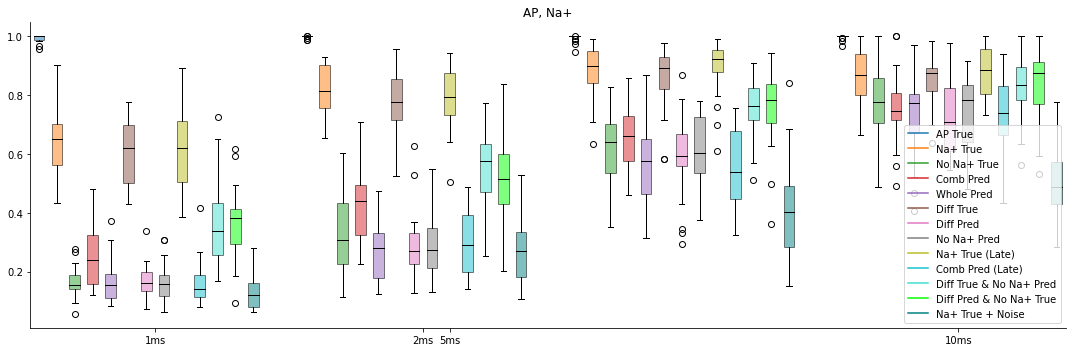

In [5]:
fig = plt.figure(constrained_layout=True, figsize = (15,5))
gs = fig.add_gridspec(1,1, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])

colors = ["tab:blue","tab:orange","tab:green",
         "tab:red","tab:purple","tab:brown","tab:pink","tab:gray",
         "tab:olive","tab:cyan","turquoise","lime", "teal"]

# first boxplot pair
bp = ax.boxplot(auc_array[0].T, positions = np.arange(0,13,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
# first boxplot pair
bp = ax.boxplot(auc_array[1].T, positions = np.arange(15,28,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
# first boxplot pair
bp = ax.boxplot(auc_array[2].T, positions = np.arange(30,43,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
# first boxplot pair
bp = ax.boxplot(auc_array[3].T, positions = np.arange(45,58,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
ax.set_xticks([6.5,21.5,23,51.5])
ax.set_xticklabels(["1ms", "2ms", "5ms", "10ms"])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_title("AP, Na+")

h1, = ax.plot(1,1,'tab:blue')
h2, = ax.plot(1,1,'tab:orange')
h3, = ax.plot(1,1,'tab:green')
h4, = ax.plot(1,1,'tab:red')
h5, = ax.plot(1,1,'tab:purple')
h6, = ax.plot(1,1,'tab:brown')
h7, = ax.plot(1,1,'tab:pink')
h8, = ax.plot(1,1,'tab:gray')
h9, = ax.plot(1,1,'tab:olive')
h10, = ax.plot(1,1,'tab:cyan')
h11, = ax.plot(1,1,'turquoise')
h12, = ax.plot(1,1,'lime')
h13, = ax.plot(1,1,'teal')

ax.legend((h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13),('AP True','Na+ True','No Na+ True','Comb Pred',
                                           'Whole Pred', 'Diff True', 'Diff Pred', 'No Na+ Pred',
                                           'Na+ True (Late)', 'Comb Pred (Late)', "Diff True & No Na+ Pred",
                                           "Diff Pred & No Na+ True", "Na+ True + Noise"))
h1.set_visible(False)
h2.set_visible(False)
h3.set_visible(False)
h4.set_visible(False)
h5.set_visible(False)
h6.set_visible(False)
h7.set_visible(False)
h8.set_visible(False)
h9.set_visible(False)
h10.set_visible(False)
h11.set_visible(False)
h11.set_visible(False)
h12.set_visible(False)
h13.set_visible(False)

fig.tight_layout()
plt.show()